Loading and preparing data...
✅ final_df created successfully.
--- Supplier Performance and Risk Report ---
Supplier financial performance ranked by Total Profit, including dispatch reliability.
    Profit_Rank  supplier_id      supplier_name Total_Revenue Total_Profit  \
3             1            4      ConsultingABC    $56,214.40   $22,061.40   
2             2            3        LabTech Ltd    $41,082.50   $17,330.50   
9             3           10     ElectronicsLim    $36,249.50   $15,225.50   
8             4            9  LabTechUltimo Ltd    $36,828.20   $15,042.70   
11            5           12           TelcoABC    $35,842.80   $14,827.30   
10            6           11        UTSTech Ltd    $33,487.30   $13,246.30   
5             7            6      ConsultingXYZ    $30,455.60   $12,763.60   
1             8            2        GadgetWorld    $29,207.60   $12,508.10   
4             9            5        Express Ltd    $23,227.60    $9,493.10   
7            10          

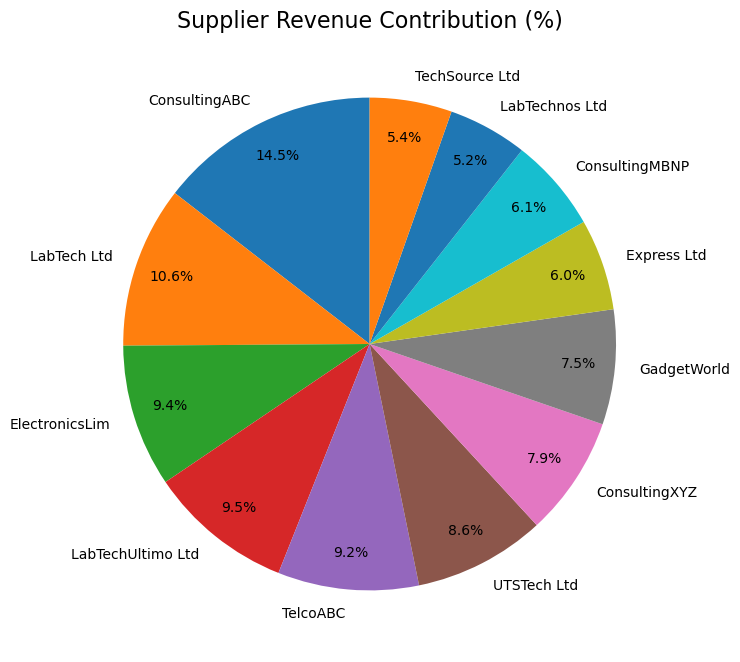

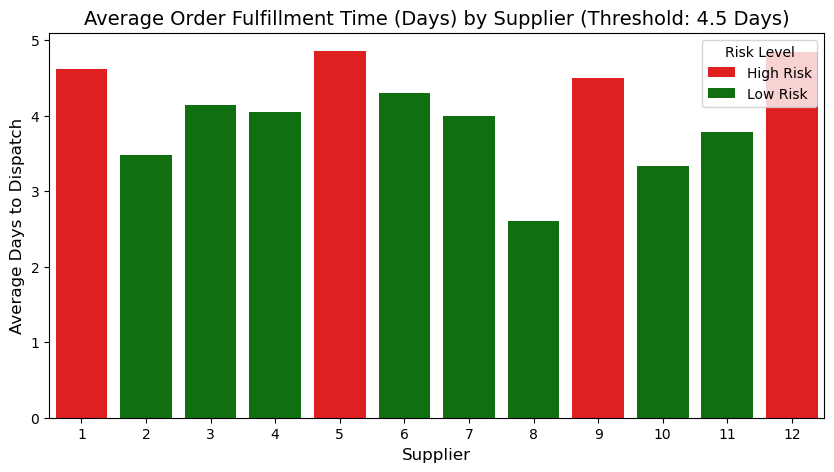

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. SETUP & DATA CREATION ---
FILES = {
    'sales': '../data/sales.csv',
    'customers': '../data/customers.csv',
    'employees': '../data/employees.csv',
    'products': '../data/products.csv',
    'sales_commission': '../data/sales_commission.csv',
    'suppliers': '../data/suppliers.csv'
}

## Ensure physical files are present 
assert 'suppliers' in dfs, "Suppliers file missing!"
assert 'sales' in dfs, "Sales file missing!"
assert 'products' in dfs, "Products file missing!"

def load_data(files):
    dfs = {}
    for name, path in files.items():
        if name == 'sales':
            try:
                dfs[name] = pd.read_csv(path, parse_dates=['sale_date', 'dispatch_date'])
            except:
                dfs[name] = pd.read_csv(path)
        else:
            dfs[name] = pd.read_csv(path)
    return dfs

def merge_data(dfs):
    # Ensure category exists
    if 'category' not in dfs['products'].columns:
        dfs['products']['category'] = 'Uncategorized'
        
    master_df = dfs['sales'].merge(
        dfs['products'][['product_id', 'product_name', 'price', 'cost_price', 'category']],
        on='product_id', how='left', suffixes=('_sales', '_product')
    )
    master_df = master_df.merge(
        dfs['suppliers'][['supplier_id', 'name', 'country']], 
        on='supplier_id', how='left'
    ).rename(columns={'name': 'supplier_name'})
     
    return master_df

def feature_engineer(df):
    df['Revenue'] = df['quantity'] * df['price']
    df['Profit'] = (df['price'] - df['cost_price']) * df['quantity']
    df['Fulfillment_Days'] = (df['dispatch_date'] - df['sale_date']).dt.days
    return df 

# --- EXECUTE SETUP ---
print("Loading and preparing data...")
dfs = load_data(FILES)
master_df = merge_data(dfs)
final_df = feature_engineer(master_df)
print("✅ final_df created successfully.")

# --- SCENARIO 5: Supplier Contribution & Risk Management ---

# 1. Aggregate Financial Metrics and Fulfillment Days by Supplier
# We group by the supplier_id (present in final_df from the sales table)
supplier_analysis = final_df.groupby(['supplier_id', 'supplier_name']).agg(
    Total_Revenue=('Revenue', 'sum'),
    Total_Profit=('Profit', 'sum'),
    Total_Sales_Count=('sale_id', 'count'),
    Avg_Fulfillment_Days=('Fulfillment_Days', 'mean')
).reset_index()

# 2. Add Supplier Ranking based on Profit
# Rank suppliers based on their total profit (Higher profit = Rank 1)
supplier_analysis['Profit_Rank'] = supplier_analysis['Total_Profit'].rank(method='min', ascending=False).astype(int)

# 3. Add Risk Flag based on Fulfillment Days
# Define a threshold for "High Risk" fulfillment (e.g., 4.5 days or more to dispatch)
RISK_THRESHOLD_DAYS = 4.5
supplier_analysis['Fulfillment_Risk'] = np.where(
    supplier_analysis['Avg_Fulfillment_Days'] >= RISK_THRESHOLD_DAYS,
    'High Risk',
    'Low Risk'
)

# 4. Format and Sort the Output Table
supplier_analysis.sort_values(by='Profit_Rank', inplace=True)

# Formatting for display
display_supplier_table = supplier_analysis.copy()
display_supplier_table['Total_Revenue'] = display_supplier_table['Total_Revenue'].apply(lambda x: f"${x:,.2f}")
display_supplier_table['Total_Profit'] = display_supplier_table['Total_Profit'].apply(lambda x: f"${x:,.2f}")
display_supplier_table['Avg_Fulfillment_Days'] = display_supplier_table['Avg_Fulfillment_Days'].round(2)


print("--- Supplier Performance and Risk Report ---")
print("Supplier financial performance ranked by Total Profit, including dispatch reliability.")
print(display_supplier_table[[
    'Profit_Rank',
    'supplier_id',
    'supplier_name',
    'Total_Revenue',
    'Total_Profit',
    'Total_Sales_Count',
    'Avg_Fulfillment_Days',
    'Fulfillment_Risk'
]])


# 5. Visualization: Revenue Contribution (Pie Chart)

plt.figure(figsize=(8, 8))
plt.pie(
    supplier_analysis['Total_Revenue'],
    labels=supplier_analysis['supplier_name'],
    autopct='%1.1f%%',  # Show percentage
    startangle=90,
    pctdistance=0.85
)
plt.title('Supplier Revenue Contribution (%)', fontsize=16)
plt.show()

# 6. Visualization: Fulfillment Risk (Bar Chart)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=supplier_analysis,
    x='supplier_id',
    y='Avg_Fulfillment_Days',
    hue='Fulfillment_Risk',
    palette={'Low Risk': 'green', 'High Risk': 'red'},
    dodge=False # Prevent double bars, but use color for emphasis
)
plt.title(f'Average Order Fulfillment Time (Days) by Supplier (Threshold: {RISK_THRESHOLD_DAYS} Days)', fontsize=14)
plt.xlabel('Supplier', fontsize=12)
plt.ylabel('Average Days to Dispatch', fontsize=12)
plt.legend(title='Risk Level')
plt.show()
